# Preproces AIS data

Load data for a specific region and time period and extract trajectories of ships.

In [1]:
# imports
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
import pandas as pd
import gym
import datetime

import os, sys

import numpy as np


from ferrygym import FerryGymEnv, Ship, plot_helpers
from MapRevMoenk import *

DATASET_NAME = 'rev-moenk-22-04-01-12-00--04-02'


path ferrygym ['/workspace/preprocessing', '/opt/conda/lib/python38.zip', '/opt/conda/lib/python3.8', '/opt/conda/lib/python3.8/lib-dynload', '', '/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages', '/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages/ferrygym']
path ferrygym ['/workspace/preprocessing', '/opt/conda/lib/python38.zip', '/opt/conda/lib/python3.8', '/opt/conda/lib/python3.8/lib-dynload', '', '/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages', '/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages/ferrygym', '/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages/ferrygym']


/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Load data

Our AIS data is stored at a Postgres server at our institute's server.
To access the data a GraphQL API is provided through [Hasura](https://hasura.io/).
This Data is not publicly available but a sample dataset is provided in `data/rev-moenk-22-04-01-12-00--04-02`


In [2]:
# connect to api
# Select your transport with a defined url endpoint
transport = AIOHTTPTransport(
    url="http://172.23.0.4:8080/v1/graphql",
    headers={'content-type': 'application/json',
        'x-hasura-admin-secret': 'aaasdsdndsfvksdsd'})

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

# Provide a GraphQL query
query = gql(
    """
    query MyQuery(
  $lteTimeString: String!,
  $gteTimeString: String!,
  $bound_bottom: float8!,
  $bound_top: float8!,
  $bound_left: float8!,
  $bound_right: float8!,
  $minSpeed: float8!) {
      ais(limit: 10000000, where: {
        datetime: {_lt: $lteTimeString, _gte: $gteTimeString},
        lon: {_is_null: false, _gte: $bound_left, _lte: $bound_right},
        lat: {_is_null: false, _gte: $bound_bottom, _lte: $bound_top},
        speed: {_is_null: false, _gt: $minSpeed},
        }) {
            mmsi
            datetime
            lat
            lon
            speed
            heading
            }
    }
"""
)

params = {"lteTimeString": "2022-04-02 12:00:00+00", "gteTimeString": "2022-04-01 12:00:00+00", "bound_right": BOUND_RIGHT, "bound_left": BOUND_LEFT, "bound_top": BOUND_TOP, "bound_bottom": BOUND_BOTTOM, "minSpeed": 0.3 }
print(params)


# Execute the query on the transport
result = await client.execute_async(query, variable_values=params)
df = pd.DataFrame(result['ais'])
# get min datetime in df
print('start data: ', df['datetime'].min())
# get max datetime in df
print('end date: ',df['datetime'].max())
# print min speed
print('min speed: ',df['speed'].min())
# print max speed
print('max speed: ',df['speed'].max())

{'lteTimeString': '2022-04-02 12:00:00+00', 'gteTimeString': '2022-04-01 12:00:00+00', 'bound_right': 10.190433, 'bound_left': 10.141767, 'bound_top': 54.352733, 'bound_bottom': 54.325583, 'minSpeed': 0.3}


ClientConnectorError: Cannot connect to host 172.23.0.4:8080 ssl:False [Connect call failed ('172.23.0.4', 8080)]

In [10]:
# replace each mmsi with a unique integer
mmsi_list = df['mmsi'].unique()
mmsi_dict = {mmsi_list[i]: i for i in range(len(mmsi_list))}
df['mmsi'] = df['mmsi'].map(mmsi_dict)

In [11]:
# Convert in env coordinates

kwargs = dict(
    generate_training_data=True,
    data_directory='/workspace/data/rev-moenk/training/',
    df_filename='2022-04-10-13->14.pkl',
)

env = FerryGymEnv.FerryGymEnv(**kwargs)
# iterate though rows
for index, row in df.iterrows():
    # get x,y from env.convertLatonInEnvCoordinates
    x, y = env.convertLatLotInEnvCoordinates(row['lat'], row['lon'])
    # set x,y in df
    df.at[index, 'x'] = x
    df.at[index, 'y'] = y

/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [12]:
# interpolate_trajectories to generate position data for every second

df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime']
df_grouped = df.groupby(['mmsi'])
df_resampled = df_grouped.resample('1S', on='datetime').mean()
df_interpol = df_resampled.interpolate()

In [13]:
# add index column and reset index
df =  df_interpol.reset_index(level=['datetime'])
# add new index column numbering the rows
df['index'] = range(0, len(df))
df.set_index('index', inplace=True)

### Calculate speed, acceleration, direction and direction_change

In [14]:
# calculate current speed and save in new column
timedelta = datetime.timedelta(seconds=1)

df['dist_x'] = df['x'].diff().fillna(0.)
df['dist_y'] = df['y'].diff().fillna(0.)
df['dist'] = (df['dist_x']**2 + df['dist_y']**2)**0.5
# add column for speed in m/s (speed column is in knots)
speed_calculated = df['dist'] / timedelta.total_seconds()
df['speed_calculated'] = speed_calculated 
# print min speed_calculated
print('min speed_calculated: ',df['speed_calculated'].min())
# print max speed_calculated
print('max speed_calculated: ',df['speed_calculated'].max())
# count speed_calculated == 0
print('count speed_calculated == 0: ',df['speed_calculated'].eq(0).sum())



min speed_calculated:  0.0
max speed_calculated:  3207.9212393395032
count speed_calculated == 0:  4292


In [15]:
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

df['dist_x']            = df['x'].diff().fillna(0.)
df['dist_y']            = df['y'].diff().fillna(0.)
df['dist']              = (df['dist_x']**2 + df['dist_y']**2)**0.5
df['speed_calculated']  = df['dist'] / timedelta.total_seconds()
df['direction']         = angle_between([0, 1], [df['dist_x'], -1 * df['dist_y']])

In [16]:
 # calculate acceleration and save in new column
acceleration = df['speed_calculated'].diff().fillna(0.)
df['acceleration'] = acceleration / timedelta.total_seconds()
# move one row up to match state
df['acceleration'] = df['acceleration'].shift(-1)

In [17]:
import numpy as np
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

df['direction'] = angle_between([0, 1], [df['dist_x'], -1 * df['dist_y']])

In [18]:
# add direction_change column
df['direction_change'] = df['direction'].diff().fillna(0)
# move one row up to match state
df['direction_change'] = df['direction_change'].shift(-1)

In [19]:
# clean up first and last row in group
mask_last_row_of_ship = df.mmsi != df.mmsi.shift(-1)
# mask_time_gap = df.datetime != df.datetime.shift(1) - timedelta
df['acceleration'][mask_last_row_of_ship] = 0
df['direction_change'][mask_last_row_of_ship] = 0
mask_first_row_of_ship = df.mmsi != df.mmsi.shift(1)
df['acceleration'][mask_first_row_of_ship] = 0
df['direction_change'][mask_first_row_of_ship] = 0
df['speed_calculated'][mask_first_row_of_ship] = df['speed_calculated'].shift(1)
df['direction'][mask_first_row_of_ship] = df['direction'].shift(1)

/tmp/ipykernel_4691/4075781168.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['acceleration'][mask_last_row_of_ship] = 0
/tmp/ipykernel_4691/4075781168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['direction_change'][mask_last_row_of_ship] = 0
/tmp/ipykernel_4691/4075781168.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['acceleration'][mask_first_row_of_ship] = 0
/tmp/ipykernel_4691/4075781168.py:8: SettingWit

In [20]:
# round actions to 2 decimals
df['acceleration'] = df['acceleration'].round(2)
df['direction_change'] = df['direction_change'].round(2)

In [21]:
# replace nan with 0
df['acceleration'] = df['acceleration'].fillna(0)
df['direction_change'] = df['direction_change'].fillna(0)
df['speed_calculated'] = df['speed_calculated'].fillna(0)
df['direction'] = df['direction'].fillna(0)

In [22]:
def move_around_the_clock(direction_change):
    if abs(direction_change) > 180:
        if direction_change > 0:
            return direction_change - 360
        else:
            return direction_change + 360
    else:
        return direction_change

df['direction_change'] = df['direction_change'].apply(move_around_the_clock)

In [23]:
# reduce to important columns
df = df[['mmsi', 'datetime', 'x', 'y', 'speed_calculated', 'acceleration', 'direction', 'direction_change']]

In [24]:
df.describe()

,mmsi,x,y,speed_calculated,acceleration,direction,direction_change
count,8.938526e+06,8.938526e+06,8.938526e+06,8.938526e+06,8.938526e+06,8.938526e+06,8.938526e+06
mean,2.091088e+01,1.225220e+03,1.507512e+03,1.661834e-01,-1.562898e-06,1.973425e+02,-1.686750e-03
std,1.353347e+01,5.665176e+02,1.280748e+03,1.059489e+00,7.883400e-02,9.075348e+01,1.983926e+00
min,0.000000e+00,1.743219e+02,0.000000e+00,0.000000e+00,-2.176000e+01,0.000000e+00,-1.800000e+02
25%,1.000000e+01,6.464050e+02,2.269204e+01,3.534664e-04,0.000000e+00,1.021056e+02,0.000000e+00
50%,1.800000e+01,1.096915e+03,1.914492e+03,1.141156e-03,0.000000e+00,2.445388e+02,0.000000e+00
75%,3.100000e+01,1.646835e+03,2.697048e+03,2.524116e-03,0.000000e+00,2.701595e+02,0.000000e+00
max,5.400000e+01,2.825311e+03,3.018942e+03,2.234272e+03,2.638000e+01,3.598309e+02,1.800000e+02


# Load dataset from file

In [13]:
# load df from pickle
# DATASET_NAME = 'rev-moenk-22-04-01-12-00--04-02'
df = pd.read_pickle('/workspace/data/' + DATASET_NAME + '/' + DATASET_NAME + '.pkl')

In [20]:
df.describe()

,mmsi,x,y,speed_calculated,acceleration,direction,direction_change
count,336752.000000,336752.000000,336752.000000,336752.000000,336752.000000,336752.000000,336752.000000
mean,8.404880,1103.571907,1963.919546,0.505336,-0.000025,124.767297,-0.005581
std,4.251106,572.819880,895.166670,4.142172,0.137944,97.371806,3.592109
min,0.000000,220.656547,0.889559,0.000000,-9.490000,0.000000,-180.000000
25%,4.000000,588.917418,1544.958019,0.000645,0.000000,58.258131,0.000000
50%,9.000000,1055.428215,1915.264013,0.002156,0.000000,102.105629,0.000000
75%,10.000000,1420.884256,2745.888811,0.068079,0.000000,200.929766,0.000000
max,21.000000,2674.318469,3018.942258,1773.433517,9.660000,358.447282,180.000000


In [21]:
# save df to pickle
df.to_pickle('/workspace/data/' + DATASET_NAME + '/' + DATASET_NAME + '.pkl')

### Generate neighborhood images

In [22]:
from pandarallel import pandarallel

import os,shutil

if os.path.isdir("/tmp") : 
    os.system('rm -R /tmp/*')

os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp'

pandarallel.initialize(nb_workers = 16, use_memory_fs = False , progress_bar=True,verbose=2 ) 

kwargs = dict(
    generate_training_data=True,
    data_directory='/workspace/data/rev-moenk/training/',
    df_filename='2022-04-10-13->14.pkl',
)

env = FerryGymEnv.FerryGymEnv(**kwargs)


def generate_images_for_group(group):
    ships = []
    for index, row in group.iterrows():
        ship = Ship.Ship((row['x'], row['y']), row['direction'], 1, row['mmsi'])
        ships.append(ship)
    for index, row in group.iterrows():
        agent = Ship.Ship((row['x'], row['y']), row['direction'], 1, row['mmsi'])
        neighborhood = env.render_neighborhood(agent, ships)
        # np save image in image directory
        filedir = row['datetime'].strftime('%Y-%m-%d') + '/' + row['datetime'].strftime('%H-%M') + '/' + row['datetime'].strftime('%S')+ '/' 
        # create directory if not exists
        if not os.path.exists('../data/' + DATASET_NAME + '/images/' + filedir):
            os.makedirs('../data/' + DATASET_NAME + '/images/' + filedir)
        filename = filedir + str(row['mmsi']) +  '.npy' 
        np.save('../data/' + DATASET_NAME + '/images/' + filename, neighborhood)
        # add filename to df
        group.at[index, 'filename'] = filename
    return group
        


df_neighborhood = df.groupby(['datetime']).parallel_apply(generate_images_for_group)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages/pandarallel/data_types/dataframe_groupby.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  iterator = iter(dataframe_groupby)


In [23]:
# remove datetime from index
df_neighborhood.reset_index(inplace=True, drop=True)

In [24]:
# save df to pickle file
print('Saving df to pickle file')
df_neighborhood.to_pickle('../data/' + DATASET_NAME + '/' + DATASET_NAME + '.pkl')

Saving df to pickle file


### Visualize data

In [26]:
df_grouped = df.groupby(['mmsi'])

In [27]:
groups = pd.concat( [ df_grouped.get_group(group) for i,group in enumerate( df_grouped.groups) if i < 1000 ] ).groupby('datetime')


In [28]:
group = groups.get_group('2022-04-01 12:07:22+00:00')
group

,mmsi,datetime,x,y,speed_calculated,acceleration,direction,direction_change,filename
index,,,,,,,,,
8415,4,2022-04-01 12:07:22+00:00,774.700280,2170.080188,0.011394,0.0,270.000000,0.0,nbi_2022-04-01 12:07:23_211223120.0.npy
166985,9,2022-04-01 12:07:22+00:00,1054.774153,1543.532359,0.023071,-0.0,140.456096,0.0,nbi_2022-04-01 12:07:23_211391280.0.npy
239202,10,2022-04-01 12:07:22+00:00,684.798014,2618.280701,0.261782,-0.0,90.683641,-0.0,nbi_2022-04-01 12:07:23_211399920.0.npy
268304,11,2022-04-01 12:07:22+00:00,749.598732,2217.044832,0.007256,-0.0,7.659794,-0.0,nbi_2022-04-01 12:07:23_211458210.0.npy
279549,12,2022-04-01 12:07:22+00:00,883.063876,1911.746665,0.007760,0.0,288.940924,0.0,nbi_2022-04-01 12:07:23_211629870.0.npy
313823,16,2022-04-01 12:07:22+00:00,1026.490369,2446.232789,4.499273,-0.0,39.326476,0.0,nbi_2022-04-01 12:07:23_257182000.0.npy


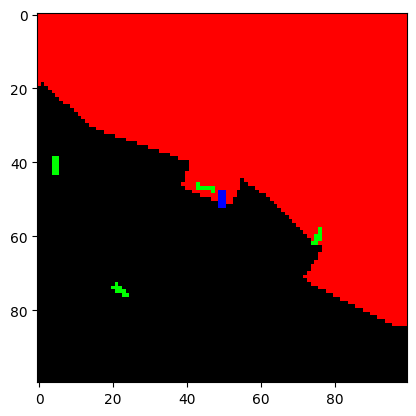

In [31]:
import matplotlib.pyplot as plt
# create ship object for every row in group

ships = []
for index, row in group.iterrows():
    ship = Ship.Ship((row['x'], row['y']), row['direction'], 1, row['mmsi'])
    ships.append(ship)

first_row = group.iloc[0]
agent = Ship.Ship((first_row['x'], first_row['y']), first_row['direction'], 1, first_row['mmsi'])
# render neighborhood
neighborhood = env.render_neighborhood(agent, ships)
# plot neighborhood
plt.imshow(neighborhood)